In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import EfficientNet_B0_Weights
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from pathlib import Path
import torch.nn.functional as F

In [2]:
# set up the path
data_path = '/home/ubuntu/landscape-aesthetics/data/external/scenicornot/scenicornot.metadata.csv'
image_folder = Path('/home/ubuntu/landscape-aesthetics/data/external/scenicornot') 

# Check if the data path exists
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Data file not found at {data_path}")

# Read the data
data = pd.read_csv(data_path)

# Check if the root directory exists
root_dir = '/home/ubuntu/landscape-aesthetics/data/external/scenicornot/'
if not os.path.exists(root_dir):
    raise FileNotFoundError(f"Root directory not found at {root_dir}")

# prepocess the dataset, remove the invalid paths
valid_files = []
missing_files = []
for idx in range(len(data)):
    img_name = data.iloc[idx]['filename']
    image_path = image_folder / Path(img_name)
    if image_path.exists():
        valid_files.append(idx)
    else:
        missing_files.append(image_path)

if missing_files:
    print(f"Missing {len(missing_files)} files:")
    for file in missing_files:
        print(file)

# only keep the valid file record
valid_data = data.iloc[valid_files].reset_index(drop=True)

Missing 1 files:
/home/ubuntu/landscape-aesthetics/data/external/scenicornot/photos/76/41/764143_e860c8c4.jpg


In [3]:
# add a weights return of the dataset class
class ScenicDataset(Dataset):
    def __init__(self, data_frame, root_dir, transform=None):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform
        # calculate the weight of each score
        self.class_weights = 1. / data_frame['average'].value_counts()
        self.data_frame['weight'] = self.data_frame['average'].map(self.class_weights)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx]['filename']) # combine root address with filename
        try:
            image = Image.open(img_name).convert('RGB')
        except (IOError, SyntaxError) as e:
          # return None, None, None
            return self.__getitem__((idx + 1) % len(self)) # return the next sample
        rating = self.data_frame.iloc[idx]['average']
        weight = self.data_frame.iloc[idx]['weight']
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(rating, dtype=torch.float32), torch.tensor(weight, dtype=torch.float32)

# centered crop
data_transforms = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
])

image_dataset = ScenicDataset(data_frame=data,
                              root_dir='/home/ubuntu/landscape-aesthetics/data/external/scenicornot/',
                              transform=data_transforms)

# seperate the training and testing sets
train_val_size = int(0.8 * len(image_dataset))
test_size = len(image_dataset) - train_val_size
train_val_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_val_size, test_size])

# seperate the training and validation set from training set
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

# modify dataloader, return weights
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

Training set size: 135587
Validation set size: 33897
Test set size: 42372


In [4]:
# utilise EfficientNet to extract deep features
class EfficientNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(EfficientNetFeatureExtractor, self).__init__()
        self.efficientnet = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.efficientnet = nn.Sequential(*list(self.efficientnet.children())[:-1])  # remove the last fully-connected layer

    def forward(self, x):
        with torch.no_grad():
            features = self.efficientnet(x)
        return features.squeeze()

feature_extractor = EfficientNetFeatureExtractor()
feature_extractor.eval()

# define a simple regression model
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [5]:
# modify the training code
def train_model(feature_extractor, scheduler, model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels, weights in train_loader:
            images, labels, weights = torch.stack(images), torch.stack(labels), torch.stack(weights)
            features = feature_extractor(images)  # replace ResNet50 feature extractor with EfficientNet
            features = features.view(features.size(0), -1)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs.squeeze(), labels)
            weighted_loss = (loss * weights).sum()  # weight loss
            weighted_loss.backward()
            optimizer.step()
            running_loss += weighted_loss.item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')
        
        # evaluate model
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels, weights in val_loader:
                images, labels, weights = torch.stack(images), torch.stack(labels), torch.stack(weights)
                features = feature_extractor(images)
                features = features.view(features.size(0), -1)
                outputs = model(features)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += (loss * weights).sum().item()

        scheduler.step()
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Validation Loss: {val_loss}')

    return train_losses, val_losses

input_dim = 1280  # change to efficientNet feature dimension
model = RegressionModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) # add a regularization term
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)  # Learning rate scheduler

# training model
# change to 7 epochs
train_losses, val_losses = train_model(feature_extractor, scheduler, model, criterion, optimizer, train_loader, val_loader, num_epochs=7) 

Epoch 1/7, Loss: 0.017397456616784195


Validation Loss: 0.017088960844082755


Epoch 2/7, Loss: 0.015162057347058248


Validation Loss: 0.011206576766139446


Epoch 3/7, Loss: 0.013517070115713698


Validation Loss: 0.012266699383269115


Epoch 4/7, Loss: 0.01262481097305941


Validation Loss: 0.010838540614788854


Epoch 5/7, Loss: 0.012153206919390985


Validation Loss: 0.01075864581020137


Epoch 6/7, Loss: 0.011990846448709692


Validation Loss: 0.011629078917408622


Epoch 7/7, Loss: 0.010852770098220554


Validation Loss: 0.010766099308074149


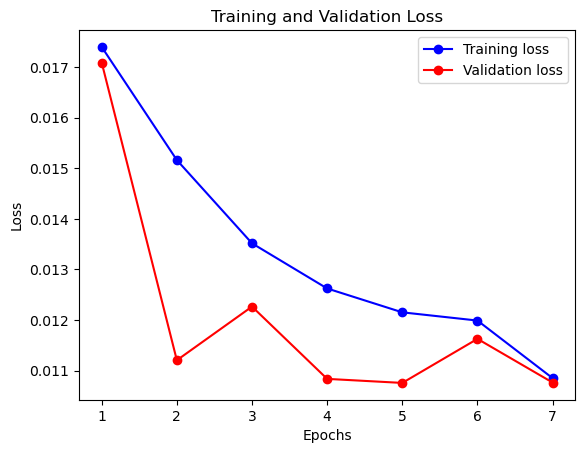

In [6]:
# plot the training and validation curves
def plot_training_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_curves(train_losses, val_losses)

In [7]:
# evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    val_labels = []
    val_predictions = []
    with torch.no_grad():
        for images, labels, weight in test_loader:
            images, labels = torch.stack(images), torch.stack(labels)
            features = feature_extractor(images)  # replace with EfficientNet
            features = features.view(features.size(0), -1)
            outputs = model(features)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item() * images.size(0)
            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(outputs.squeeze().cpu().numpy())
    
    test_loss /= len(test_loader.dataset)
    mae = mean_absolute_error(val_labels, val_predictions)
    r2 = r2_score(val_labels, val_predictions)
    print(f'Test Loss: {test_loss}')
    print(f'Validation MAE: {mae}')
    print(f'Validation R²: {r2}')
    
    return test_loss, mae, r2, val_labels, val_predictions

tl, mae, r2, val_labels, val_predictions = evaluate_model(model, test_loader)

Test Loss: 1.2417321745986745
Validation MAE: 0.8832151889801025
Validation R²: 0.5171077748829349


In [8]:
# save the model
# torch.save(model.state_dict(), '/home/ubuntu/landscape-aesthetics/models/efficientNet_weights_1.pth')
# print("Model saved to efficientNet_weights_1.pth")

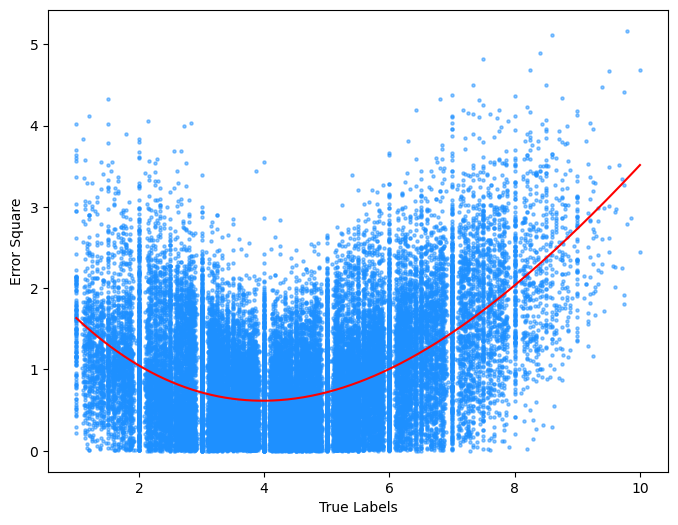

In [9]:
errors2 = np.sqrt((np.array(val_labels) - np.array(val_predictions)) ** 2)

plt.figure(figsize=(8, 6))
plt.scatter(val_labels, errors2, alpha=0.5, s=5, c='#1E90FF')
plt.xlabel('True Labels')
plt.ylabel('Absolute Error')
# plt.title('Scatter Plot of Prediction Errors Square vs True Labels')

degree_of_fit = 3 
z = np.polyfit(val_labels, errors2, degree_of_fit)  
p = np.poly1d(z)  

x_range = np.linspace(min(val_labels), max(val_labels), 500)  
plt.plot(x_range, p(x_range), color='red', label=f'{degree_of_fit} degree fit')

plt.show()

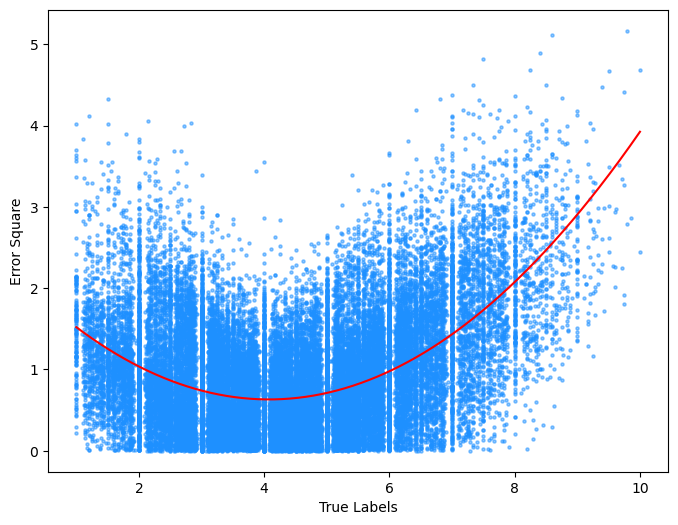

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(val_labels, errors2, alpha=0.5, s=5, c='#1E90FF')
plt.xlabel('True Labels')
plt.ylabel('Absolute Error')

degree_of_fit = 2
z = np.polyfit(val_labels, errors2, degree_of_fit)  
p = np.poly1d(z)  

x_range = np.linspace(min(val_labels), max(val_labels), 500)  
plt.plot(x_range, p(x_range), color='red', label=f'{degree_of_fit} degree fit')

plt.show()

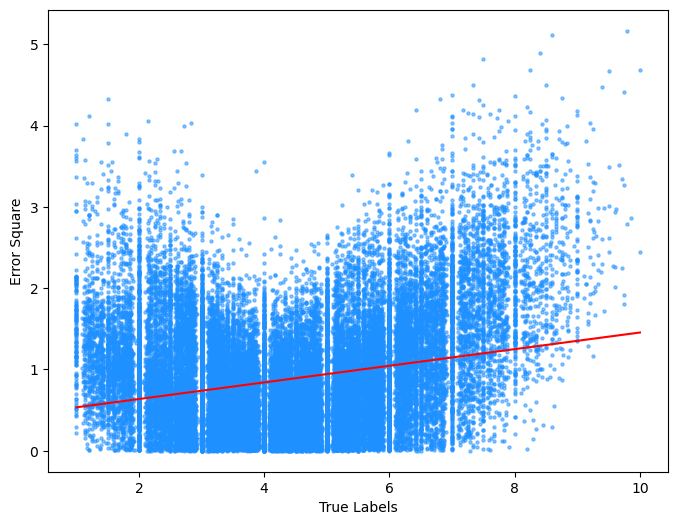

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(val_labels, errors2, alpha=0.5, s=5, c='#1E90FF')
plt.xlabel('True Labels')
plt.ylabel('Absolute Error')

degree_of_fit = 1
z = np.polyfit(val_labels, errors2, degree_of_fit)  
p = np.poly1d(z)  

x_range = np.linspace(min(val_labels), max(val_labels), 500)  
plt.plot(x_range, p(x_range), color='red', label=f'{degree_of_fit} degree fit')

plt.show()

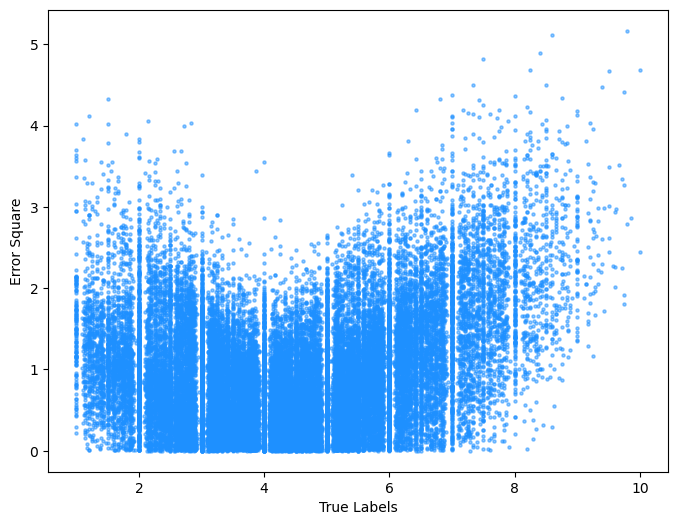

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(val_labels, errors2, alpha=0.5, s=5, c='#1E90FF')
plt.xlabel('True Labels')
plt.ylabel('Absolute Error')

plt.show()

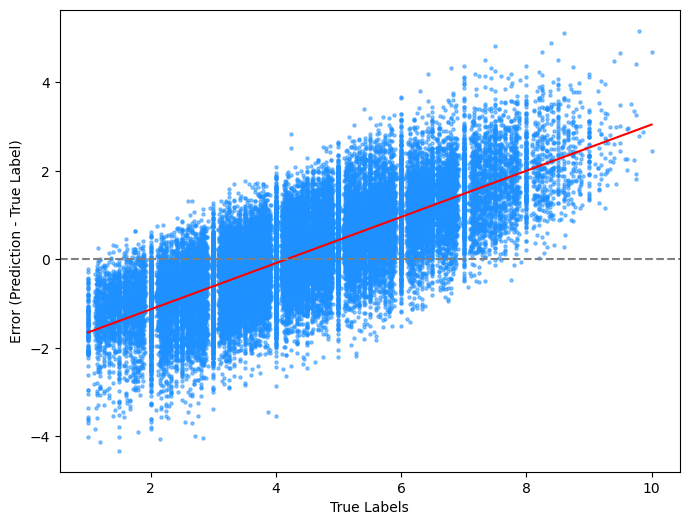

In [13]:
errors = np.array(val_labels) - np.array(val_predictions)

plt.figure(figsize=(8, 6))
plt.scatter(val_labels, errors, alpha=0.5, s=5, c='#1E90FF')
plt.xlabel('True Labels')
plt.ylabel('Error (Prediction - True Label)')
# plt.title('Scatter Plot of Prediction Errors vs True Labels')

degree_of_fit = 1 
z = np.polyfit(val_labels, errors, degree_of_fit)  
p = np.poly1d(z)  

x_range = np.linspace(min(val_labels), max(val_labels), 500)  
plt.plot(x_range, p(x_range), color='red', label=f'{degree_of_fit} degree fit')

plt.axhline(y=0, color='grey', linestyle='--')

plt.show()

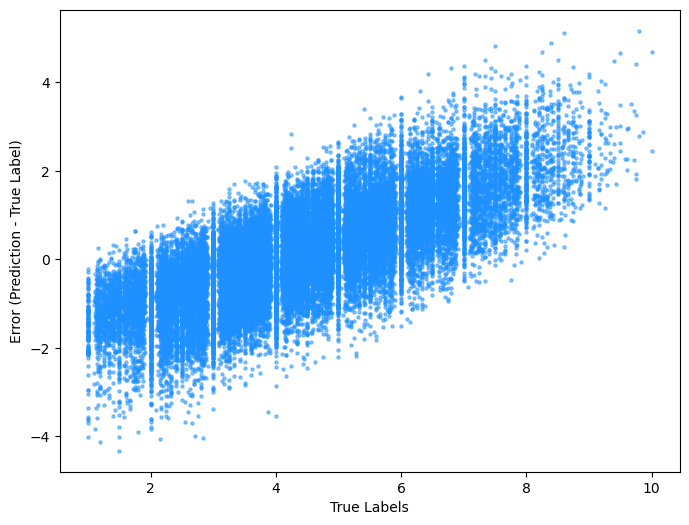

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(val_labels, errors, alpha=0.5, s=5, c='#1E90FF')
plt.xlabel('True Labels')
plt.ylabel('Error (Prediction - True Label)')
# plt.title('Scatter Plot of Prediction Errors vs True Labels')

plt.show()

In [ ]:
# wrong y-axis name